In [1]:
! pip install transformers datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 9.7 MB/s eta 0:00:00


In [2]:
! pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.9 MB/s eta 0:00:00


In [3]:
import torch
torch.cuda.empty_cache()

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [7]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch import optim
import sys
import random
import math
import time
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

from transformers import BertTokenizer, AutoTokenizer
from transformers import BertModel, AutoModel, AutoModelForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from torch.utils.tensorboard import SummaryWriter

use_cuda = True if torch.cuda.is_available() else False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# use_cuda=False
# device='cpu'

torch.autograd.set_detect_anomaly(True)
torch.backends.cudnn.benchmark = True
np.random.seed(0)
torch.manual_seed(0)

base_model = 'xlm-roberta-base'
model_list = ['bert-base-uncased', 'bert-base-multilingual-uncased', 'google/muril-base-cased', 'xlm-roberta-base',
              'ai4bharat/indic-bert','cardiffnlp/twitter-xlm-roberta-base','cardiffnlp/twitter-xlm-roberta-base-sentiment',
              'cardiffnlp/twitter-roberta-base', 'cardiffnlp/twitter-roberta-base-sentiment',
              'cardiffnlp/twitter-roberta-base-hate', 'roberta-base']
model_path = '/content/drive/MyDrive/saved_models/'
results_path = '/content/drive/MyDrive/saved_results/'

In [8]:
lang = 'portuguese'
model_choice = 6

In [9]:
writer = SummaryWriter(log_dir="/content/drive/MyDrive/" + base_model + "_" + lang)
device

device(type='cuda')

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_list[model_choice])

MAX_SEQ_LEN = 128

label_idx = 1
text_idx = 0

class HateData(Dataset):
    def __init__(self, data_path, split='train', lang='bengali', aug_prob=0.2, flip_prob=0.5):
        self.split = split
        # self.data = pd.read_parquet(data_path + lang + "_" + split + ".parquet", engine='fastparquet')
        # self.data = pd.read_csv(data_path, sep=',')
        # self.data = pd.read_csv(data_path + lang + "_" + split + ".tsv", sep='\t')
        self.data = pd.read_csv(data_path + split + "_" + lang + ".tsv", sep='\t', lineterminator='\n')

        if self.split == 'train':
            self.label2data = {0:[], 1:[], 2:[]}
            # self.data = self.data[self.data['language'] == lang]

            for i in tqdm(range(len(self.data))):
                row = self.data.iloc[i]
                self.label2data[row[label_idx]].append(row[text_idx])
            self.aug_prob = aug_prob
            self.flip_prob = flip_prob

    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        data = self.data.iloc[index]

        labels = data[label_idx]
        text = data[text_idx]
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=MAX_SEQ_LEN)
        # print(inputs)
        input_ids = inputs['input_ids']
        token_type_ids = np.zeros(MAX_SEQ_LEN)#inputs['token_type_ids']#
        attn_mask = inputs['attention_mask']

        aug_text = text
        labels_aug = labels

        if self.split == 'train' and labels == 1:
            if np.random.uniform() < self.aug_prob:
                aug_text = np.random.choice(self.label2data[0])

                if np.random.uniform() < self.flip_prob:
                    aug_text = aug_text + " [SEP] " + text
                else:
                    aug_text = text + " [SEP] " + aug_text
            labels_aug = 1

        inputs_aug = tokenizer(aug_text, padding='max_length', truncation=True, max_length=MAX_SEQ_LEN)
        # print(inputs)
        input_ids_aug = inputs_aug['input_ids']
        token_type_ids_aug = np.zeros(MAX_SEQ_LEN)#inputs_aug['token_type_ids']#
        attn_mask_aug = inputs_aug['attention_mask']

        input_ids = torch.tensor(np.vstack([input_ids, input_ids_aug]), dtype=torch.long).view(2, MAX_SEQ_LEN)
        token_type_ids = torch.tensor(np.vstack([token_type_ids, token_type_ids_aug]), dtype=torch.long).view(2, MAX_SEQ_LEN)
        attn_mask = torch.tensor(np.vstack([attn_mask, attn_mask_aug]), dtype=torch.long).view(2, MAX_SEQ_LEN)
        labels = torch.tensor(np.vstack([labels, labels_aug]), dtype=torch.long).view(2)


        return input_ids, attn_mask, token_type_ids, labels


# train_data = HateData(data_path="/home/jupyter/data/implicit-hate-corpus/", lang='latent')
# dataload = DataLoader(train_data, batch_size=4)

# for i in (dataload):
#     print(i[0].shape)
#     print(i[1].shape)
#     print(i[2].shape)
#     print(i[3].shape)
#     break




In [11]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        H1, H2, num_class = 768, 128, 2
        self.bert = AutoModel.from_pretrained(model_list[model_choice])

        # for param in self.bert.parameters():
        #     param.requires_grad = False

        self.clf = nn.Sequential(
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, H2),
            nn.ReLU(),
            nn.Linear(H2, num_class)
        )


    def forward(self, input_ids, attn_mask, token_type_ids):
        outputs = self.bert(input_ids, attn_mask)#, token_type_ids)
        cls_emb = outputs.pooler_output # (batch, 768)
        logits = self.clf(cls_emb) # (batch, num_class)
        return logits


In [12]:
loss_fn = nn.CrossEntropyLoss()#

In [13]:
def train(input_ids, attn_mask, token_type_ids, label, model, model_opt, scdl):

    model_opt.zero_grad()

    batch_size = input_ids.shape[0]
    seq_len = input_ids.shape[1]

    loss = 0.0

    if use_cuda:
        input_ids = input_ids.to(device)
        attn_mask = attn_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        label = label.to(device)

    # label = label.flatten()

    logits = model(input_ids[:,0,:], attn_mask[:,0,:], token_type_ids[:,0,:])
    logits_aug = model(input_ids[:,1,:], attn_mask[:,1,:], token_type_ids[:,1,:])

    loss = loss_fn(logits, label[:,0]) + loss_fn(logits_aug, label[:,1])

    # if torch.isnan(loss):
    #     pass
    # else:
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # clip gradients to prevent exploding
    model_opt.step()
    scdl.step()
    # print(loss)
    return float(loss.item())



In [14]:
def evaluate(input_ids, attn_mask, token_type_ids, label, model, mode='train'):

    batch_size = input_ids.shape[0]
    seq_len = input_ids.shape[1]


    with torch.no_grad():
        if use_cuda:
            input_ids = input_ids.to(device)
            attn_mask = attn_mask.to(device)
            token_type_ids = token_type_ids.to(device)
            label = label.to(device)

        # label = label.flatten()

        logits = model(input_ids[:,0,:], attn_mask[:,0,:], token_type_ids[:,0,:])
        loss = loss_fn(logits, label[:,0])

        if mode == 'train':
            return float(loss.item())

        preds = torch.argmax(logits, dim=1).flatten()
        # acc = (preds == label).cpu().numpy().mean() * 100

        return float(loss.item()), preds.cpu().numpy()




In [15]:
df_test = pd.read_csv("/content/drive/MyDrive/data_efficient_hatedetect/data/multilingual/test_portuguese.tsv", sep='\t', lineterminator='\n')
gt_labels = np.array(df_test['label'])

In [16]:
len(gt_labels)

284

In [17]:
def trainIters(model, epochs, train_loader, test_loader, learning_rate=3e-5, log_step=168, valid_step=168, mode='train'):

    model_opt = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    num_train_steps = (len(train_loader)*epochs)
    scdl = get_linear_schedule_with_warmup(model_opt, num_warmup_steps=int(0.1*num_train_steps), num_training_steps=num_train_steps)

    print("Initialised optimizer and lr scheduler")

    # valid_best_loss = []
    best_acc = 0.0
    tot = len(train_data) // train_loader.batch_size
    tot_val = len(val_data) // test_loader.batch_size
    plot_steps = 0

    for epoch in range(epochs):
        train_loss_total = 0.0
        train_step = 0
        # Training

        model.train()
        for entry in tqdm(train_loader, total=tot, position=0, leave=True):
            loss = train(entry[0], entry[1], entry[2], entry[3], model, model_opt, scdl)
            plot_steps += 1
            train_step += 1
            # if not math.isnan(loss) :
            train_loss_total = train_loss_total + loss

            train_loss = train_loss_total / train_step

            if plot_steps % log_step == 0:
                writer.add_scalar("Train Loss", train_loss, plot_steps)

            if (plot_steps % valid_step == 0) or (plot_steps >= num_train_steps - 1):
                model.eval()
                test_pred = []

                for entry in tqdm(test_loader, total=tot_val, position=0, leave=True):
                    loss_v, pred_v = evaluate(entry[0], entry[1], entry[2], entry[3], model, mode='test')
                    # if not math.isnan(loss) :
                    test_pred.extend([pd for pd in pred_v])

                # val_acc = (test_pred == gt_labels).mean().item()
                val_acc = f1_score(gt_labels, test_pred, average='macro')
                print("Validation F1: " + str(val_acc))
                writer.add_scalar("Val F1", val_acc, plot_steps)


                #   Save best model
                # state = {
                #         'epoch': epoch,
                #         'state_dict': model.state_dict(),
                #         'optimizer': model_opt.state_dict(),
                #         'loss': train_loss,
                #         'scheduler': scdl.state_dict(),
                # }


                if val_acc > best_acc:
                    torch.save(model.state_dict(), model_path + "model_" + base_model + "_" + lang + "_easymix_mono_redo" + ".pth")
                    print("Model saved for step: " + str(plot_steps))
                    best_acc = val_acc

                model.train()
            writer.flush()


        print('epoch: '+str(epoch))
        print('total loss: '+str(train_loss_total/tot))

        # wr_train = open(results_path + "train_loss_" + base_model + ".txt", "a")
        # wr_train.write("epoch " + str(epoch) + ": " + str(train_loss_total/tot) + "\n")
        # wr_train.close()




In [18]:
train_data = HateData(data_path="/content/drive/MyDrive/data_efficient_hatedetect/data/multilingual/", split='train', lang=lang)
val_data = HateData(data_path="/content/drive/MyDrive/data_efficient_hatedetect/data/multilingual/", split='test', lang=lang)

100%|██████████| 5386/5386 [00:00<00:00, 14090.74it/s]


In [19]:
BS = 16
# weights = [1.0]*15383
# weights.extend([0.5]*(len(train_data) - 15383))
# sampler = WeightedRandomSampler(weights, num_samples=20000)

dataload = DataLoader(train_data, batch_size=BS, shuffle=True)
dataload_val = DataLoader(val_data, batch_size=BS, shuffle=False)

In [20]:
(len(train_data)/16)//2

168.0

In [21]:
# model = Classifier()
# model = model.float()
# # model = nn.DataParallel(model)#, device_ids = [2, 3]
# model = model.to(device)
model = Classifier()
# model = nn.DataParallel(model)
#model.load_state_dict(torch.load("/content/drive/MyDrive/saved_models/model_twitter-xlm-roberta-base-sentiment_multilingual_redo.pth", map_location=device))
model = model.to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
trainIters(model, 5, dataload, dataload_val)

Initialised optimizer and lr scheduler


18it [00:02,  7.97it/s]                        


Validation F1: 0.6182795698924731


 50%|█████     | 168/336 [04:29<25:20,  9.05s/it]

Model saved for step: 168


18it [00:02,  8.28it/s]                        


Validation F1: 0.7116090146750524


100%|██████████| 336/336 [08:37<00:00,  4.89s/it]

Model saved for step: 336


337it [08:38,  1.54s/it]


epoch: 0
total loss: 1.1167137053396021


18it [00:02,  8.32it/s]                        


Validation F1: 0.716135381587243


 50%|████▉     | 167/336 [04:10<20:07,  7.14s/it]

Model saved for step: 504


18it [00:02,  8.06it/s]                        
100%|█████████▉| 335/336 [08:03<00:01,  1.93s/it]

Validation F1: 0.681932892320098


337it [08:06,  1.44s/it]


epoch: 1
total loss: 0.8005551160091445


18it [00:02,  8.08it/s]                        
 49%|████▉     | 166/336 [03:49<05:55,  2.09s/it]

Validation F1: 0.6511056511056512


18it [00:02,  8.20it/s]                        
 99%|█████████▉| 334/336 [07:42<00:04,  2.17s/it]

Validation F1: 0.6867647058823529


337it [07:46,  1.38s/it]


epoch: 2
total loss: 0.5349549885085296


18it [00:02,  8.19it/s]                        
 49%|████▉     | 165/336 [03:46<06:09,  2.16s/it]

Validation F1: 0.6843470206853968


18it [00:02,  8.37it/s]                        
 99%|█████████▉| 333/336 [07:38<00:06,  2.22s/it]

Validation F1: 0.6897692997472895


337it [07:43,  1.38s/it]


epoch: 3
total loss: 0.3027159272792882


18it [00:02,  7.99it/s]                        
 49%|████▉     | 164/336 [03:44<05:29,  1.91s/it]

Validation F1: 0.6734511027819672


18it [00:02,  7.89it/s]
 99%|█████████▉| 332/336 [07:34<00:07,  1.92s/it]

Validation F1: 0.6811981977825959


18it [00:02,  8.46it/s]                        
100%|██████████| 336/336 [07:46<00:00,  2.68s/it]

Validation F1: 0.6811981977825959


18it [00:02,  8.29it/s]                        
337it [07:49,  1.39s/it]

Validation F1: 0.6811981977825959
epoch: 4
total loss: 0.16612676974009014


######################## TESTING ######################

In [23]:
lang = 'portuguese'

In [24]:
model = Classifier()
# model = nn.DataParallel(model)
model.load_state_dict(torch.load("/content/drive/MyDrive/saved_models/model_twitter-xlm-roberta-base-sentiment_" + lang + "_easymix_mono" + "_redo.pth", map_location=device))
model = model.to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
lang='spanish'

In [26]:
# test_data = HateData(data_path="/home/jupyter/data/test_data/bq_test_" + lang + "_process_10k.csv")
test_data = HateData(data_path="/content/drive/MyDrive/data_efficient_hatedetect/data/multilingual/", split='test', lang=lang)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [27]:
model.eval()
test_loss = []
test_pred = []

# wr = open(results_path + "test_prediction_" + base_model + "_" + lang + "_process_10k.txt", "w")
wr = open(results_path + "test_prediction_" + base_model + "_" + lang + ".txt", "w")
for entry in tqdm(test_loader, total=len(test_data)//test_loader.batch_size, position=0, leave=True):
    v_loss, v_pred = evaluate(entry[0], entry[1], entry[2], entry[3], model, mode='test')
    test_loss.append(v_loss)
    test_pred.append(v_pred)
    wr.write(str(v_pred)+"\n")

test_loss = np.mean(test_loss)#.item()

print("Test Loss: ", test_loss)

wr.close()

100%|██████████| 1600/1600 [00:23<00:00, 67.53it/s]

Test Loss:  0.6882004590588622


In [28]:
df_test = pd.read_csv("/content/drive/MyDrive/data_efficient_hatedetect/data/multilingual/test_spanish.tsv", sep='\t', lineterminator='\n')
gt_labels = np.array(df_test['label'])

In [30]:
print(classification_report(gt_labels, test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8664    0.4000    0.5473       940
           1     0.5163    0.9121    0.6594       660

    accuracy                         0.6112      1600
   macro avg     0.6913    0.6561    0.6033      1600
weighted avg     0.7220    0.6112    0.5935      1600



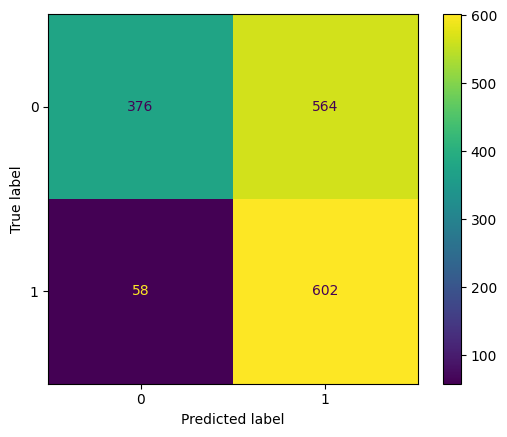

In [31]:
ConfusionMatrixDisplay.from_predictions(gt_labels, np.array(test_pred))